In [67]:
import sys
import os
sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))    # So can access functions in isca_tools which is in home/Isca directory
import isca_tools
from metpy.calc import moist_static_energy, saturation_mixing_ratio, specific_humidity_from_mixing_ratio
from metpy.units import units
import numpy as np
import matplotlib.pyplot as plt

In [64]:
# Load dataset
exp_name = 'convective_coupling/aquaplanet/d5'
ds = isca_tools.load_dataset(exp_name)
namelist = isca_tools.load_namelist(exp_name)  # Need this for albedo_value
albedo = namelist['mixed_layer_nml']['albedo_value']
tau = namelist['two_stream_gray_rad_nml']['atm_abs']
p_full = namelist['spectral_dynamics_nml']['reference_sea_level_press']     # pressure of entire atmosphere in Pa

## Spin up
The net flux converges, even if not exactly towards 0. I am still not sure if the $(1-\alpha \exp^{-\tau})$ prefactor is correct.
I use this prefactor because, on way from space to surface, shortwave radiation gets absorbed due to shortwave optical depth so
that the fraction of incoming that reaches the surface is $\exp^{-\tau}$.
A fraction $\alpha$ of this then gets reflected and returns to space.
[Isca](https://execlim.github.io/Isca/modules/two_stream_gray_rad.html#frierson-byrne-schemes) has no absorption of shortwave radiation of this upward reflected shortwave radiation.

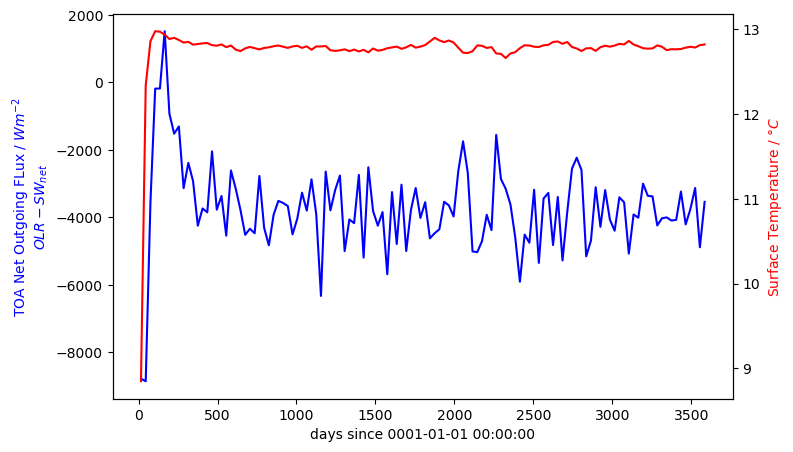

In [13]:
# Plot spin up time
fig, ax = plt.subplots(1,1, figsize=(8, 5))
isca_tools.plot.plot_spin_up(ds.olr, ds.swdn_toa*(1-albedo*np.exp(-tau)), ds.temp_2m, ax)

## Moist static energy
Want to see whether moist static energy is conserved i.e. same at surface and in free troposphere for each latitude.

In [22]:
# Take time and zonal mean
# Use all data after 3 years, as clearly converged from the above spin up plot
ds_use = ds.sel(time=slice(360*3, np.inf)).mean(dim=['lon', 'time'])

In [114]:
# Get near surface moist static energy as function of latitude using 2m variables
mse_2m = moist_static_energy(2 * units.meters, ds_use.temp_2m * units.kelvin,
                             ds_use.sphum_2m * units.kilogram/units.kilogram)


In [94]:
# Sanity check to make sure that surface specific humidity is less than saturation specific humidity.
# I.e. check that saturation q calculation is correct
q_sat_2m = specific_humidity_from_mixing_ratio(saturation_mixing_ratio(p_full * units.Pa, ds_use.temp_2m * units.kelvin))
rh_2m = ds_use.sphum_2m / q_sat_2m
print("Max Surface Relative Humidity: {:.3f}".format(rh_2m.to_numpy().max()))

Max Surface Relative Humidity: 0.977


In [87]:
# Free troposphere MSE at 700hPa - units of pressure in dataset are hPa
ds_ft = ds_use.sel(pfull=700, method='nearest')
q_sat_ft = specific_humidity_from_mixing_ratio(saturation_mixing_ratio(p_full * units.Pa, ds_ft.temp * units.kelvin))
mse_ft = moist_static_energy(ds_ft.height * units.meters, ds_ft.temp * units.kelvin,
                             q_sat_ft * units.kilogram/units.kilogram)

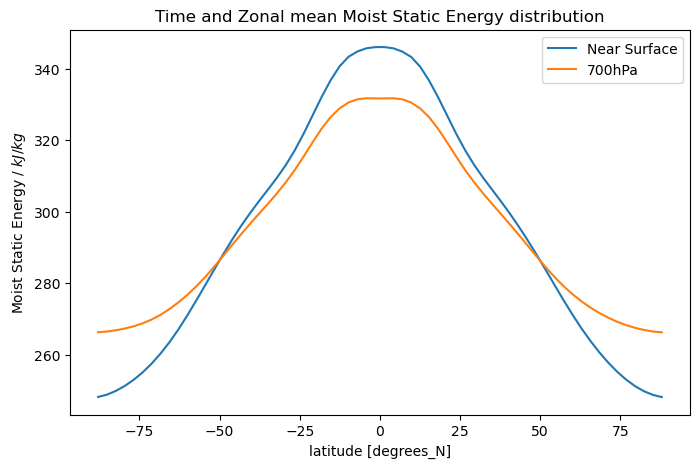

In [134]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
mse_2m.plot.line(ax=ax, add_legend=False, label="Near Surface")
mse_ft.plot.line(ax=ax, add_legend=False, label="700hPa")
ax.legend();
ax.set_ylabel('Moist Static Energy / $kJ/kg$');
ax.set_title('Time and Zonal mean Moist Static Energy distribution');

This plot shows that the moist static energy at the surface is not equal to the saturation moist static energy in the free troposphere, as we would expect if it was convectively coupled.

In [152]:
# Consider each latitude and pressure value and compute saturation MSE
q_sat_all = specific_humidity_from_mixing_ratio(saturation_mixing_ratio(p_full * units.Pa, ds_use.temp * units.kelvin))
mse_all = moist_static_energy(ds_use.height * units.meters, ds_use.temp * units.kelvin,
                             q_sat_all * units.kilogram/units.kilogram)
mse_all.name = 'saturation moist static energy';

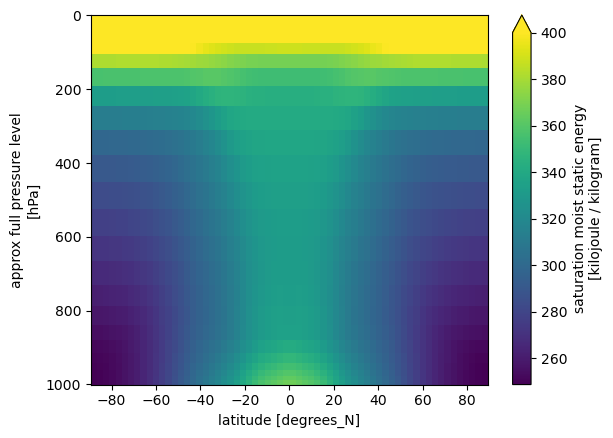

In [153]:
mse_all.plot(vmax=400, yincrease=False);

From this plot, it appears that in the tropics, the saturation MSE is constant from about 900hPa up to around 400hPa.